<a href="https://colab.research.google.com/github/IsaacFigNewton/PMF-Classifier/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO

1.  Integrate an inverse-distance kernel weighting mechanism to improve accuracy.

  a. Ensure that the weight assigned to each neighbor is inversely proportional to its distance from the target point.


2.  Add Feature-Dependent Weighting:

  a. Develop a weighting scheme based on the percentage of variability in the class attributable to each feature.

  b. Adjust the influence of each feature in the final decision-making process according to its calculated weight.

  c. Test the impact of this feature-weighted approach on the overall model performance.



# Import Libraries and Config

In [1]:
from itertools import chain

import numpy as np
from collections import defaultdict
import pandas as pd
import json
import seaborn as sns
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                      check_is_fitted,\
                                      check_array
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,\
                                      KBinsDiscretizer,\
                                      OneHotEncoder,\
                                      StandardScaler
from sklearn.neighbors import KernelDensity,\
                                      KNeighborsRegressor,\
                                      KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,\
                                      MultinomialNB
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score,\
                                      make_scorer
from sklearn.model_selection import KFold,\
                                      GridSearchCV,\
                                      cross_val_score,\
                                      cross_validate

In [90]:
# Prepare for k-fold cross-validation
n_neighbors = 1
max_bins = 50

# Define the parameter grid
param_grid = {
    'regressor__n_neighbors': range(1, 2),
    'regressor__max_bins': list(chain(range(2, 10, 2), range(10, 110, 10)))
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Regressor Class

In [3]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, max_bins=None, alpha=1e-9, n_neighbors=1):
        # Max bins for discretization, to limit memory usage
        self.max_bins = max_bins
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors

        self.X_ = None
        self.y_ = None
        self.classes = None

        self.prior_class_probabilities = None
        # Accessible in the form pmf_dict[class][feature][unique_value]
        self.pmf_dict = None
        # self.pmf_df.columns = ["class", "feature", "unique_value", "prob"]
        self.pmf_df = None
        self.discretizer_store = None
        self.knn_model_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X_ = X
        self.y_ = y
        self.classes = np.unique(y)

        self.prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        self.pmf_dict = {class_value: {feature: {} for feature in range(self.X_.shape[1])} for class_value in self.classes}

        # create a dict of discretizers for discretizing input features (if desired)
        self.discretizer_store = {feature: None for feature in range(self.X_.shape[1])}
        # create a dict to store PMFs for each feature and unique value
        self.knn_model_store = {\
                                  class_value: {\
                                                feature: defaultdict() for feature in range(self.X_.shape[1])\
                                                }\
                                  for class_value in self.classes\
                                }

        # map knn_model_store to a dataframe
        pmf_df = {
            "class": list(),
            "feature": list(),
            "unique_value": list(),
            "prob_class": list(),
            "prob_unique_val_given_feature": list()
        }

        # Calculating and storing PMFs
        for class_value in self.classes:
            for feature in range(self.X_.shape[1]):
                # print(f"class: {class_value}, feature: {feature}")
                # print(self.X_[:, feature])
                # Get unique values for the current feature
                # default; discretize down to scale of datapoints
                unique_values = np.unique(self.X_[:, feature])
                # print("Unique values: ", unique_values)


                # alternate; discretize down to datapoints or max_bins
                if self.max_bins is not None and len(unique_values) > self.max_bins:
                    # store discretizer for later reapplication to test data
                    self.discretizer_store[feature] = KBinsDiscretizer(n_bins=self.max_bins, encode='ordinal', strategy='quantile')
                    self.discretizer_store[feature] = self\
                                                                      .discretizer_store[feature]\
                                                                      .fit(unique_values.reshape(-1, 1))
                    current_discretizer = self.discretizer_store[feature]

                    # transform the current unique value set
                    unique_values = current_discretizer\
                                        .transform(unique_values\
                                                   .reshape(-1, 1))\
                                        .flatten()

                    # discretize the dataset as a whole for the current feature
                    self.X_[:, feature] = current_discretizer\
                                            .transform(self.X_[:, feature]\
                                                       .reshape(-1, 1))\
                                            .flatten()

                # Calculate the weighted probability for each unique value
                for unique_value in unique_values:
                    # Calculate the pmf value for the current class, feature and unique value
                    pmf_val, p_unique = self.calc_pmf_at_value(class_value, feature, unique_value)

                    # Add the weighted probabilities of the unique value to the feature distribution set
                    self.pmf_dict[class_value][feature][unique_value] = pmf_val#, p_unique)

                    pmf_df["class"].append(class_value)
                    pmf_df["feature"].append(feature)
                    pmf_df["unique_value"].append(unique_value)
                    pmf_df["prob_class"].append(pmf_val)
                    pmf_df["prob_unique_val_given_feature"].append(p_unique)

        # create a dataframe from the probabilities
        self.pmf_df = pd.DataFrame.from_dict(pmf_df, dtype="float64")
        # print(self.pmf_df.head())
        # print(self.pmf_df["unique_value"].unique())
        # print(self.pmf_dict)

        if len(self.pmf_dict[class_value][feature].keys()) != len(self.pmf_df["unique_value"].unique()):
          print(f"ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();\
          {len(self.pmf_dict[class_value][feature].keys())} != {len(self.pmf_df['unique_value'].unique())}")
          print(self.pmf_dict[class_value][feature].keys())
          print(self.pmf_df["unique_value"].unique())

        for class_value in self.classes:
            for feature in range(self.X_.shape[1]):
                # Create a KNN for the current feature
                pmf = self.create_pmf_using_knn(class_value, feature)

                # Store the KNN for the current feature and class
                self.knn_model_store[class_value][feature] = pmf

        # Return the fitted model
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes.dtype)

        for feature in range(X.shape[1]):
            # alternate; discretize down to datapoints or max_bins
            if self.discretizer_store[feature] is not None:
                # discretize the test dataset as a whole on every feature
                X[:, feature] = self.discretizer_store[feature]\
                                        .transform(self.X_[:, feature]\
                                                    .reshape(-1, 1))\
                                        .flatten()

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)
            # print(class_probabilities)
            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************

     # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y_ == class_value) / len(self.X_)


    # Function to calculate probability distribution
    def calc_pmf_at_value(self, class_value, feature, unique_value):
        # Calculate P(unique_val | feature)
        mask = self.X_[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X_)

        # Filter the dataset for the current class and feature value
        class_mask = self.y_ == class_value
        class_data_mask = mask & class_mask

        # Calculate P(unique_val | feature /\ class)
        p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

        # Avoid division by zero
        if p_unique > 0:
            # Calculate P(unique_val | feature /\ class)/P(unique_val | feature)
            pmf_value = p_unique_given_class / p_unique
        else:
            # No data for this unique value
            pmf_value = self.alpha

        return pmf_value, p_unique


    # Function to get values and their associated probabilities for the current feature and class
    def get_feature_class_vals_and_probs(self, class_value, feature):
        pmf_class_feature = self.pmf_dict[class_value][feature]

        # print(pmf_class_feature)

        # Get the values for the current feature and class
        values = np.array(\
                                list(\
                                    pmf_class_feature.keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(\
                                 list(\
                                      pmf_class_feature.values()))

        return values, probabilities


    # Function to create a KNN for prob_distribution in the current feature and class
    def create_pmf_using_knn(self, class_value, feature):
        values, probabilities = self.get_feature_class_vals_and_probs(class_value, feature)

        # print()
        # print(values)
        # print(probabilities)
        # print()
        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    def get_standardized_feature_contributions(self):
      # Get the sum of squares of all residuals

      # Get the residuals of all the points on the discretized PMF
      squared_residuals = self.pmf_df.sub(self.y_, axis=0) ** 2

      # Get the sum of squares (SS) for each feature
      sum_of_squares = squared_residuals.sum()

      return np.divide(squared_residuals, sum_of_squares)


    # get the weights for each neighbor of a test datapoint in a given feature
    def get_knn_weighted_avg(self,
                            class_value,
                            feature, value,
                            neighbor_indices,
                            neighbor_distances):
        values, probabilities = self.get_feature_class_vals_and_probs(class_value, feature)
        neighbor_values = values[neighbor_indices]


        # handle edge cases where something went horribly wrong
        #   and where n_neighbors = 1 and thus the only weight will be 0
        if len(neighbor_values) == 0:
            return 0
        elif len(neighbor_values) == 1:
            return probabilities[neighbor_indices[0]]

        # get modified inverse distance weights
        standardized_distances = np.divide(neighbor_distances,
                                     np.sum(neighbor_distances))
        distance_weights = np.divide(1 - standardized_distances,
                                     np.sum(standardized_distances))

        weighted_avg = np.average(probabilities[neighbor_indices],
                                  weights=distance_weights)

        # print(neighbor_distances)
        # print(standardized_distances)
        # print(distance_weights)

        return weighted_avg



    # Function to calculate P(class | discretized feature1_value /\ discretized feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                datapoint = np.array([[value]])
                model = self.knn_model_store[class_value][feature]

                # Get the custom weighted KNN estimate for the current datapoint, feature, and class
                # Get the neighbors of the current datapoint and their indices in
                distances, indices = model.kneighbors(X=datapoint, n_neighbors=n_neighbors)
                # print("datapoint: ", datapoint)
                # print("neighbor distances: ", distances)
                # print("neighbor values: ", distances)
                # print("neighbor indices: ", indices)

                # datapoint_class_likelihood = self.get_knn_weighted_avg(class_value,
                #                                                  feature,
                #                                                  datapoint,
                #                                                  indices,
                #                                                  distances)
                # print()

                datapoint_class_likelihood = model.predict(datapoint)
                # print(datapoint_class_likelihood)

                # Accumulate features' weighted probabilities
                #   and multiply by the standardized feature contributions to the data's output
                likelihood *= datapoint_class_likelihood# * self.standardized_feature_contributions[feature]

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def pmf_dict_to_dict(self):
        return {
            class_value: {
                feature: (list(self.pmf_dict[class_value][feature].keys()),
                          list(self.pmf_dict[class_value][feature].values()))
                for feature in range(self.X_.shape[1])
            } for class_value in self.classes
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.pmf_dict_to_dict())

## Utility

In [4]:
# Custom transformer to convert sparse matrix to dense
def to_dense(X):
    return np.array(X.todense()) if hasattr(X, 'todense') else X

dense_transformer = FunctionTransformer(to_dense)

In [5]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

In [6]:
def cv_results_to_dict(pipeline, X, y):
    model_name = pipeline.steps[-1][0]

    # Perform cross-validation
    cv_results = cross_validate(pipeline,
                                X,
                                y,
                                cv=kf,
                                scoring=scoring,
                                return_train_score=False)

    # Calculate average scores and standard deviations
    avg_scores[model_name] = {
            "precision": cv_results['test_precision'].mean(),
            "recall": cv_results['test_recall'].mean(),
            "accuracy": cv_results['test_accuracy'].mean(),
            "f1": cv_results['test_f1'].mean(),
            "std_precision": cv_results['test_precision'].std(),
            "std_recall": cv_results['test_recall'].std(),
            "std_accuracy": cv_results['test_accuracy'].std(),
            "std_f1": cv_results['test_f1'].std(),
    }

    # Print average scores
    print("\nAverage Scores:")
    print(f"Precision: {avg_scores[model_name]['precision']:.4f} (+/- {avg_scores[model_name]['std_precision']:.4f})")
    print(f"Recall: {avg_scores[model_name]['recall']:.4f} (+/- {avg_scores[model_name]['std_recall']:.4f})")
    print(f"Accuracy: {avg_scores[model_name]['accuracy']:.4f} (+/- {avg_scores[model_name]['std_accuracy']:.4f})")
    print(f"F1 Score: {avg_scores[model_name]['f1']:.4f} (+/- {avg_scores[model_name]['std_f1']:.4f})")

    # If you want to see individual fold scores:
    for fold, (precision, recall, accuracy, f1) in enumerate(zip(
        cv_results['test_precision'],
        cv_results['test_recall'],
        cv_results['test_accuracy'],
        cv_results['test_f1']
    ), 1):
        print(f"\nFold {fold}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Import and Clean Dataset

In [120]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno"], inplace=True)
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

# take a sample for faster testing
dataset = dataset.loc[:200]
print(len(dataset))

# Identify categorical, continuous, and binary columns
quantitative_vars = ["age", "fare"]
categorical_vars = []#"gender", "embarked", "class", "country"]
X = quantitative_vars + categorical_vars

y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

201


,gender,age,class,embarked,country,fare,survived
0,male,42.0,3rd,S,United States,7.11,0
1,male,13.0,3rd,S,United States,20.05,0
2,male,16.0,3rd,S,United States,20.05,0
3,female,39.0,3rd,S,England,20.05,1
4,female,16.0,3rd,S,Norway,7.13,1


In [121]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('continuous', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer)
])

pipeline.fit(dataset[X])
transformed_feature_names = pipeline[:-1].get_feature_names_out()

# transform the dataset
transformed_dataset = pd.DataFrame(pipeline.transform(dataset[X]),
                                   columns=transformed_feature_names)
# add the y values back in, after resetting their indices
transformed_dataset[y[0]] = dataset[y[0]].reset_index(drop=True)
transformed_dataset.head()

,continuous__age,continuous__fare,survived
0,0.981797,-0.463258,0
1,-1.092717,-0.273960,0
2,-0.878113,-0.273960,0
3,0.767192,-0.273960,1
4,-0.878113,-0.462966,1


In [122]:
transformed_X = transformed_dataset[transformed_feature_names]
transformed_y = transformed_dataset[y[0]].map(class_map)

## Bug checking

In [123]:
transformed_dataset[transformed_dataset.isnull().any(axis=1)]

,continuous__age,continuous__fare,survived


In [124]:
len(transformed_dataset)

201

In [125]:
transformed_dataset.dropna(inplace=True)
len(transformed_dataset)

201

# Data Exploration

## Figures

In [98]:
# # Parse the loose JSON representation into a dataframe

# # Initialize an empty list to store the rows
# rows = []

# # Iterate through the dictionary to extract the data
# for class_value, features in pmf_dict_x_y.items():
#     for feature, (x_values, y_values) in features.items():
#         # Create a DataFrame for the current feature
#         df_feature = pd.DataFrame({
#             'Class': class_value,
#             'Feature': feature,
#             'Feature Value': x_values,
#             'Weighted Probability': y_values
#         })
#         # Append the DataFrame to the rows list
#         rows.append(df_feature)

# # Concatenate all rows into a single DataFrame
# df = pd.concat(rows, ignore_index=True)

# df

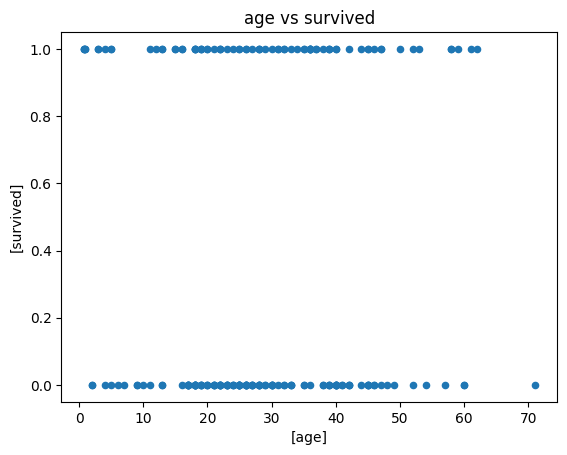

In [99]:
dataset.plot.scatter(x=[quantitative_vars[0]], y=y)
plt.title(f"{quantitative_vars[0]} vs {y[0]}")
plt.show()

## Ensure the custom implementation runs (for debugging)

### Simple validation approach

In [100]:
for neighbors in param_grid["regressor__n_neighbors"]:
  for bins in param_grid["regressor__max_bins"]:
    model = PMFRegressor(n_neighbors=neighbors, max_bins=bins)
    model = model.fit(transformed_X, transformed_y)
    predictions = model.predict(transformed_X)

    print(predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]


In [101]:
print(len(predictions), transformed_X.shape[0])

201 201


### Slightly more complex validation approach

In [102]:
# Initialize your custom regressor
regressor = PMFRegressor()

np_transformed_X = transformed_X
np_transformed_y = transformed_y

# Convert transformed_X to a NumPy array if it's a DataFrame
if isinstance(np_transformed_X, pd.DataFrame):
    np_transformed_X = np_transformed_X.values
if isinstance(np_transformed_y, pd.DataFrame):
    np_transformed_y = np_transformed_y.values

# Cross-validation loop
for train_index, test_index in kf.split(np_transformed_X):
    X_train, X_test = np_transformed_X[train_index], np_transformed_X[test_index]
    y_train, y_test = np_transformed_y[train_index], np_transformed_y[test_index]

    # Fit the model on the training set
    regressor.fit(X_train, y_train)

    # Predict on the test set
    y_pred = regressor.predict(X_test)

    # Calculate metrics
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Store metrics
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)

# Convert metrics to a DataFrame for easy viewing
results_df = pd.DataFrame({
    'Fold': range(1, len(precisions) + 1),
    'Precision': precisions,
    'Recall': recalls,
    'Accuracy': accuracies,
    'F1': f1_scores
})

# Calculate average scores across all folds
avg_scores = results_df.mean()

print("Cross-Validation Results:")
print(results_df)
print("\nAverage Scores:")
print(avg_scores)

precisions, recalls, accuracies, f1_scores = [], [], [], []

ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]
Cross-Validation Results:
   Fold  Precision    Recall  Accuracy        F1
0     1   0.699540  0.682927  0.682927  0.687633
1     2   0.745000  0.700000  0.700000  0.706905
2     3   0.626250  0.625000  0.625000  0.625235
3     4   0.773333  0.775000  0.775000  0.773667
4     5   0.620000  0.600000  0.600000  0.604040
5     6   0.402142  0.634146  0.634146  0.492173
6     7   0.422500  0.650000  0.650000  0.512121
7     8   0.275625  0.525000  0.525000  0.361475
8     9   0.360000  0.600000  0.600000  0.450000
9    10   0.360000  0.600000 

# Cross Validation Against other Models

In [103]:
transformed_dataset.head()

,continuous__age,continuous__fare,survived
0,0.981797,-0.463258,0
1,-1.092717,-0.273960,0
2,-0.878113,-0.273960,0
3,0.767192,-0.273960,1
4,-0.878113,-0.462966,1


In [104]:
# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

avg_scores = dict()

## Sklearn Classifiers

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin


Average Scores:
Precision: 0.0000 (+/- 0.0000)
Recall: 0.0000 (+/- 0.0000)
Accuracy: 0.6018 (+/- 0.0431)
F1 Score: 0.0000 (+/- 0.0000)

Fold 1
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6341
F1 Score: 0.0000

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5250
F1 Score: 0.0000

Fold 4
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000

Fold 5
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000


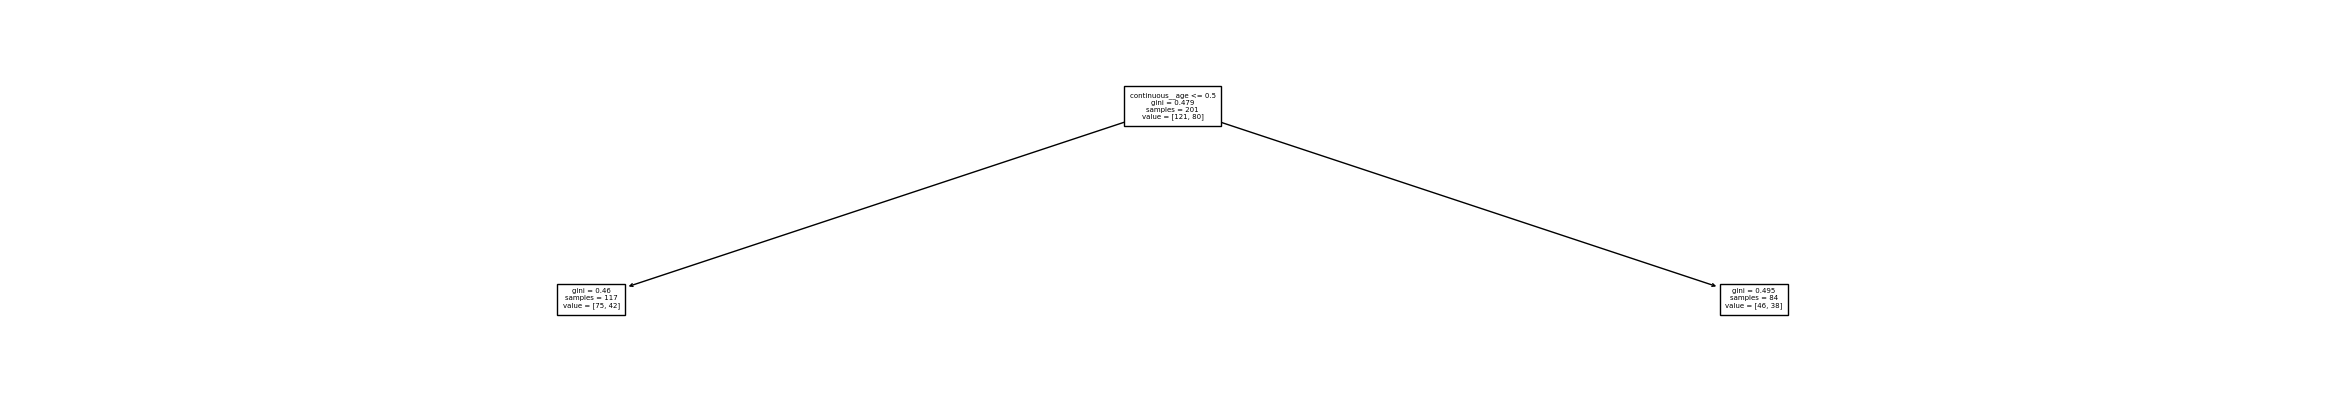

In [105]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline([
    ('decision tree classifier', DecisionTreeClassifier())
])

cv_results_to_dict(pipeline, transformed_X, transformed_y)

# Fit the pipeline to the data
pipeline.fit(transformed_X, transformed_y)

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['decision tree classifier'],
                  max_depth=5,
                  feature_names=transformed_feature_names,
                  fontsize=5,
                  ax=ax)

plt.show()

In [106]:
# Create a pipeline with preprocessor and KNeighborsClassifier
pipeline = Pipeline([
    ('knn classifier', KNeighborsClassifier(n_neighbors=n_neighbors))
])

cv_results_to_dict(pipeline, transformed_X, transformed_y)


Average Scores:
Precision: 0.2232 (+/- 0.1987)
Recall: 0.3487 (+/- 0.3656)
Accuracy: 0.4882 (+/- 0.1345)
F1 Score: 0.2520 (+/- 0.2188)

Fold 1
Precision: 0.3659
Recall: 1.0000
Accuracy: 0.3659
F1 Score: 0.5357

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.5000
Recall: 0.3684
Accuracy: 0.5250
F1 Score: 0.4242

Fold 4
Precision: 0.2500
Recall: 0.3750
Accuracy: 0.3000
F1 Score: 0.3000

Fold 5
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline([
    ('gaussian naive bayes classifier', GaussianNB())
])


cv_results_to_dict(pipeline, transformed_X, transformed_y)


Average Scores:
Precision: 0.0696 (+/- 0.1391)
Recall: 0.1000 (+/- 0.2000)
Accuracy: 0.5668 (+/- 0.0830)
F1 Score: 0.0821 (+/- 0.1641)

Fold 1
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6341
F1 Score: 0.0000

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5250
F1 Score: 0.0000

Fold 4
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000

Fold 5
Precision: 0.3478
Recall: 0.5000
Accuracy: 0.4250
F1 Score: 0.4103


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

In [108]:
# Create a pipeline with preprocessor and SVM classifier
pipeline = Pipeline([
    ('svm classifier', SVM())
])

cv_results_to_dict(pipeline, transformed_X, transformed_y)


Average Scores:
Precision: 0.0000 (+/- 0.0000)
Recall: 0.0000 (+/- 0.0000)
Accuracy: 0.6018 (+/- 0.0431)
F1 Score: 0.0000 (+/- 0.0000)

Fold 1
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6341
F1 Score: 0.0000

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5250
F1 Score: 0.0000

Fold 4
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000

Fold 5
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin

In [109]:
# Create a pipeline with preprocessor and MLP classifier
pipeline = Pipeline([
    ('mlp classifier', MLP())
])

cv_results_to_dict(pipeline, transformed_X, transformed_y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Average Scores:
Precision: 0.0000 (+/- 0.0000)
Recall: 0.0000 (+/- 0.0000)
Accuracy: 0.6018 (+/- 0.0431)
F1 Score: 0.0000 (+/- 0.0000)

Fold 1
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6341
F1 Score: 0.0000

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5250
F1 Score: 0.0000

Fold 4
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000

Fold 5
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
# Create a pipeline with preprocessor and RandomForestClassifier classifier
pipeline = Pipeline([
    ('rf classifier', RandomForestClassifier())
])

cv_results_to_dict(pipeline, transformed_X, transformed_y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defin


Average Scores:
Precision: 0.0000 (+/- 0.0000)
Recall: 0.0000 (+/- 0.0000)
Accuracy: 0.6018 (+/- 0.0431)
F1 Score: 0.0000 (+/- 0.0000)

Fold 1
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6341
F1 Score: 0.0000

Fold 2
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6500
F1 Score: 0.0000

Fold 3
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.5250
F1 Score: 0.0000

Fold 4
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000

Fold 5
Precision: 0.0000
Recall: 0.0000
Accuracy: 0.6000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Custom Approach

In [128]:
# Create a scorer dictionary
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

pipeline = Pipeline([
    ("regressor", PMFRegressor())
])

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    # Use the same KFold object as before
    cv=kf,
    scoring="f1_weighted",
    # Refit using the best F1 score
    refit='f1',
    return_train_score=False,
    # Use all available cores
    n_jobs=-1,
    verbose=3
)
# Fit the GridSearchCV object
grid_search.fit(transformed_X, transformed_y)

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Process the results
avg_scores["custom"] = dict()
f1_by_k_bin_count = {
    "k": list(),
    "bin_count": list(),
    "f1": list()
}

blah
Fitting 5 folds for each of 14 candidates, totalling 70 fits
blah


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [112]:
for i, row in results.iterrows():
    k = row['param_regressor__n_neighbors']
    bin_count = row['param_regressor__max_bins']
    if k not in avg_scores["custom"]:
        avg_scores["custom"][k] = dict()
    avg_scores["custom"][k][bin_count] = {
        "precision": row['mean_test_precision'],
        "recall": row['mean_test_recall'],
        "accuracy": row['mean_test_accuracy'],
        "f1": row['mean_test_f1'],
        "std_precision": row['std_test_precision'],
        "std_recall": row['std_test_recall'],
        "std_accuracy": row['std_test_accuracy'],
        "std_f1": row['std_test_f1']
    }
    f1_by_k_bin_count["k"].append(k)
    f1_by_k_bin_count["bin_count"].append(bin_count)
    f1_by_k_bin_count["f1"].append(row['mean_test_f1'])

# Convert f1_by_k to DataFrame
f1_by_k_bins = pd.DataFrame.from_dict(f1_by_k_bin_count)
print(f1_by_k_bins.head())

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# You can now use the best model for predictions
best_model = grid_search.best_estimator_

   k  bin_count  f1
0  1          2 NaN
1  1          4 NaN
2  1          6 NaN
3  1          8 NaN
4  1         10 NaN
Best parameters: {'regressor__max_bins': 2, 'regressor__n_neighbors': 1}
Best F1 score: nan


In [113]:
optimal_k = grid_search.best_params_['regressor__n_neighbors']
optimal_bin_count = grid_search.best_params_['regressor__max_bins']
optimal_run = avg_scores["custom"][optimal_k][optimal_bin_count]

print(f"Optimal k: {optimal_k}")
print(f"Optimal max bin count: {optimal_bin_count}")

Optimal k: 1
Optimal max bin count: 2


### Results

In [114]:
print(f1_by_k_bins.head())

   k  bin_count  f1
0  1          2 NaN
1  1          4 NaN
2  1          6 NaN
3  1          8 NaN
4  1         10 NaN


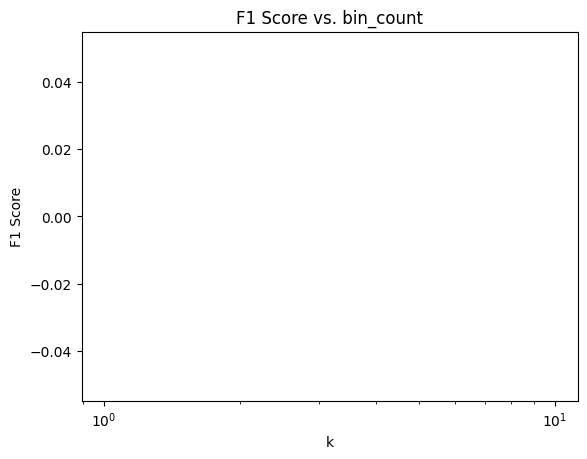

In [115]:
plt.plot(f1_by_k_bins["bin_count"], f1_by_k_bins["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. bin_count")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.xscale("log")
plt.show()

In [116]:
# Print optimal scores
print()
print("Average Scores for Best Run (optimal k and bin_count):")
print(f"n_neighbors = {optimal_k}")
print(f"max_bins = {optimal_bin_count}")
print(f"Precision: {optimal_run['precision']:.4f} (+/- {optimal_run['std_precision']:.4f})")
print(f"Recall: {optimal_run['recall']:.4f} (+/- {optimal_run['std_recall']:.4f})")
print(f"Accuracy: {optimal_run['accuracy']:.4f} (+/- {optimal_run['std_accuracy']:.4f})")
print(f"F1 Score: {optimal_run['f1']:.4f} (+/- {optimal_run['std_f1']:.4f})")


Average Scores for Best Run (optimal k and bin_count):
n_neighbors = 1
max_bins = 2
Precision: nan (+/- nan)
Recall: nan (+/- nan)
Accuracy: nan (+/- nan)
F1 Score: nan (+/- nan)


In [117]:
model = best_model.fit(transformed_X, transformed_y)
y_pred = pd.Series(model.predict(transformed_X))

ERROR: UNIQUE VALUE COUNT MISMATCH IN self.fit();          1 != 2
dict_keys([1.0])
[0. 1.]


In [118]:
transformed_feature_names

array(['continuous__age', 'continuous__fare'], dtype=object)

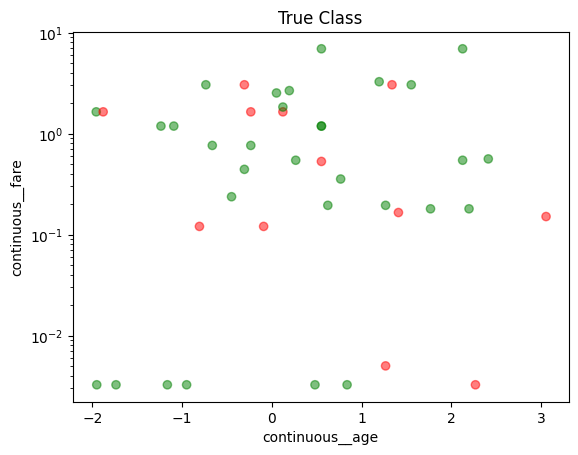

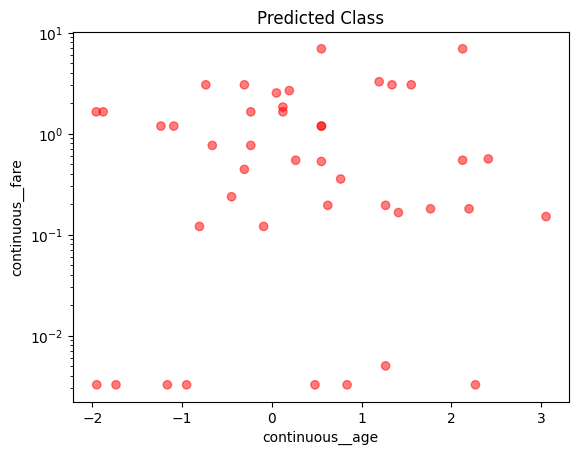

In [119]:
transformed_quant_names = ["continuous__" + quantitative_vars[i] for i in range(len(quantitative_vars))]
plot_types_colors = [("True Class", transformed_y.map(colormap)),
                     ("Predicted Class", y_pred.map(colormap))]

if len(quantitative_vars) > 1:
  for plot_type, color in plot_types_colors:
      plt.scatter(transformed_dataset[transformed_quant_names[0]],\
                  transformed_dataset[transformed_quant_names[1]],\
                  c=color,\
                  alpha=0.5)

      # Add labels and title
      plt.title(plot_type)
      plt.xlabel(transformed_quant_names[0])
      plt.ylabel(transformed_quant_names[1])
      plt.yscale('log')
      plt.show()

# Compare Models

In [ ]:
for model_name, scores in avg_scores.items():
      if model_name != "custom":
          print(f"{model_name}:")
          print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
          print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
          print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
          print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
          print()
      else:
          print(f"{model_name}:")
          print(f"Optimal n_neighbors = {optimal_k}")
          print(f"Precision: {optimal_run['precision']:.4f} (+/- {optimal_run['std_precision']:.4f})")
          print(f"Recall: {optimal_run['recall']:.4f} (+/- {optimal_run['std_recall']:.4f})")
          print(f"Accuracy: {optimal_run['accuracy']:.4f} (+/- {optimal_run['std_accuracy']:.4f})")
          print(f"F1 Score: {optimal_run['f1']:.4f} (+/- {optimal_run['std_f1']:.4f})")
          print()

In [ ]:
# Prepare data for plotting
models = list(avg_scores.keys())
metrics = ['precision', 'recall', 'accuracy', 'f1']
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(optimal_run[metric])
        else:
            values.append(avg_scores[model][metric])
    ax.bar(x + i*width, values, width, label=metric)

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.3, 1)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(optimal_run[metric])
        else:
            values.append(avg_scores[model][metric])
    for j, v in enumerate(values):
        ax.text(j + i*width, v, f'{v:.2f}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()